In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
large = screen_funds('Equities', 'Domestic', 'Large-Cap')
mid = screen_funds('Equities', 'Domestic', 'Mid-Cap')
small = screen_funds('Equities', 'Domestic', 'Small-Cap')
print(len(large), len(mid), len(small))
quote = Quote(large + mid + small, 90, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

80 20 21
from 2019-04-22 to 2019-07-18 - 121


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

94


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
MTUM,58,0.148798,0.337103,0.416683,9.466345,2.859384
USMV,58,0.124966,0.271360,0.429809,7.943837,2.180427
SPLV,58,0.118132,0.281143,0.390543,7.737980,2.660443
PDP,58,0.113760,0.382359,0.275728,7.211259,3.974186
FPX,58,0.111635,0.387734,0.266423,7.110045,5.445800
ADX,58,0.099908,0.333520,0.274571,6.308771,5.318352
VIG,58,0.088444,0.319000,0.251129,5.262985,4.634193
JKE,58,0.080426,0.392411,0.183718,4.888443,7.390317
IWP,58,0.076852,0.393213,0.174253,5.029775,6.491853


evicted VLUE 0.896 0.696
evicted FDL 0.858 0.709
evicted ADX 0.813 0.737
evicted XSLV 0.674 0.674
retry backlogs ['MDYG', 'ONEQ', 'IJK', 'VOO', 'VONG', 'IWB', 'RSP', 'SCHV', 'VXF', 'SPY', 'GSLC', 'FEX', 'VUG', 'SPLG', 'IWP', 'VYM', 'VTV', 'SCHX', 'VOE', 'IWR', 'DLN', 'IUSG', 'VOOG', 'VV', 'IVE', 'VONV', 'VTI', 'SCHB', 'DGRO', 'IWD', 'MGV', 'OEF', 'IWV', 'IVV', 'MGC', 'IVW', 'SPYG', 'VONE', 'ITOT', 'SPTM', 'PKW', 'VO', 'VB', 'IWY', 'SPYV', 'PRF', 'SCHG', 'FNDX', 'DSI', 'PDP', 'VIG', 'SDY', 'VBK', 'QUAL', 'FTCS', 'SPLV', 'JHMM', 'QDF', 'LRGF', 'PWV', 'FPX', 'XMLV', 'SPHD', 'MOAT', 'MGK', 'IUSV', 'SCHM', 'SPYD', 'DGRW', 'MTUM', 'SDOG', 'SUSA', 'IWS', 'IYY', 'FVD', 'IWF', 'VOT', 'FV', 'IWO', 'SPHQ', 'TILT', 'QQQ', 'JKE', 'HDV', 'RPG', 'NOBL', 'DVY', 'DIA', 'USA'] at 0.905/-0.51 - 0.43
evicted IWO 0.833 0.657
evicted USA 0.811 0.780
retry backlogs ['IWR', 'VV', 'SCHX', 'SPYV', 'DSI', 'GSLC', 'IUSG', 'VOOG', 'SCHB', 'VTV', 'IWV', 'VOO', 'IWY', 'IWB', 'VTI', 'IVE', 'SPTM', 'DGRO', 'VUG', 'SPY

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
USMV,58.0,0.124966,0.271360,-0.355133,-0.033145,0.107282,0.270778,0.844584,0.429809,7.943837,2.180427
Portfolio,58.0,0.134027,0.292583,-0.375988,-0.038522,0.113181,0.298976,0.905949,0.429601,8.520868,2.309378
MTUM,58.0,0.148798,0.337103,-0.476787,-0.071637,0.143408,0.353391,1.172438,0.416683,9.466345,2.859384


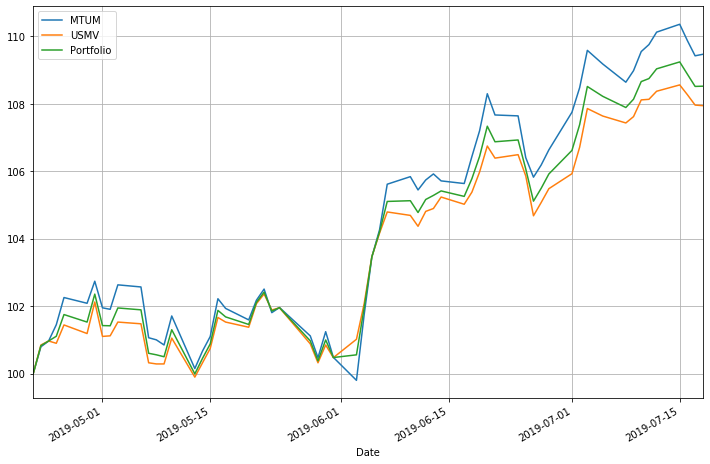

In [6]:
bounds = .12, .16
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=1, bounds=bounds)
quote.setup_mask(['MTUM', 'USMV'])
sd = quote.optimize_portfolio(_lambda=1, bounds=bounds)
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=1, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)